In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATTERY_PARTS = [
    '281700','282200','392020','392051','392119','392310', 
    '420212','721240','722230','722699','730120','730690', 
    '732619','732620','740822','740919','740921','741011', 
    '741220','741533','750522','750610','750620','760612', 
    '760719','790700','810590','831110','831120','831190', 
    '850110','850120','850590','850640','850660','850730', 
    '850780','853223','853340','854190','854370','854519', 
    '854720','860900','391910','391990','392069','731822', 
    '854449','391732','280430','290123','292390','281122', 
    '390230','853223','854720','760410','740990','853223', 
    '854720','760410','740990','282300','284210','740811', 
    '853630','382499','761699','830249','854411','848049', 
    '850790','732690','280440','854290','731816','830230', 
    '392099','401699','730711','741999','850680','853222', 
    '390210','382490','854442','282110','853890','853610', 
    '850450','732599','392690','730890','731100','853641'
]

BATTERY_PARTS_DICT = {
    'Aluminum foil': ['760410','760612','760719','761699'],
    'Anode Paste': ['281122','282110','282300','281700'],
    'Copper foil': ['740811','740822','740919','740921','740990','741011','741220','741533'],
    'Cathode': ['810590','280430'],
    'Cathode Paste': ['282200'],
    'Electrolyte': ['382499','292390','284210','290123','280440','382490'],
    'Battery Separator': ['390210','390230','401699'],
    'Anode': ['790700','854519'],
    'Cylinder Cell': ['731100'],
    'Spacer': ['392310','392020'],
    'Wire': ['831120','831190'],
    'Cases': ['721240','722230','722699','730120','730690','730890','731816','731822','732599','732619','732620','391732','391910','391990','392051','392069','392099','392690','848049','860900','854720','420212'],
    'Nickel Tab': ['750522','750610','750620'],
    'Battery Cell': ['850640','850660','850680'],
    'BMS':['850450','850730','850780','850790','853222','853223','853321','853340','853630','853641','853890','854190','854239','854290','854411','854442','854449'],
    'BATTERY': ['850760']
}

from collections import defaultdict
INV_BATTERY_PARTS_DICT = defaultdict()
for key, value in BATTERY_PARTS_DICT.items():
    for v in value:
        INV_BATTERY_PARTS_DICT[v] = key

BATTERY = '850760'
NUM_SUPPLIERS = 100

# Get Top Suppliers of Battery

In [3]:
index = pd.read_csv("s3://supply-web-data-storage/CSV/index_hs6.csv")

In [4]:
# Check for missing values
index[index['hs6'] == BATTERY].isna().sum()

supplier_t      0
supplier_id     0
buyer_t         1
buyer_id        1
hs6             0
st              0
et              0
bill_count      0
quantity_sum    0
weight_sum      0
amount_sum      0
dtype: int64

In [5]:
def generate_battery_suppliers(index, method_name=None, count=NUM_SUPPLIERS, df_print=False):   
    if method_name is not None:
        top_suppliers_df = index[index['hs6'] == BATTERY].groupby('supplier_t').agg(
                               indicator_value=(method_name, 'sum')
                           ).sort_values(
                               ["indicator_value"], ascending = False
                           )
    else:
        raise ValueError('Must specify a method for defining largest supplier.')
    if df_print: 
        pd.set_option('display.max_rows', count+1)
        print(top_suppliers_df.head(count))
        pd.reset_option("all")
    top_suppliers = top_suppliers_df.head(count).index
    assert len(top_suppliers) == count
    return top_suppliers

In [6]:
battery_suppliers = generate_battery_suppliers(index, method_name="bill_count", df_print=True)
battery_suppliers

                                                    indicator_value
supplier_t                                                         
dell global b.v                                                6060
wistron corporation                                            3845
sevt                                                           2540
hp international sarl                                          2298
yiwu yihuang import export compan                               826
sehc                                                            689
samsung electronics vietnam thai nguyen co.,ltd                 658
cong ty tnhh dien tu samsung hcmc ce complex                    631
verdant crest technology dmcc                                   508
luxshare precision limited                                      437
railhead corporation                                            421
navitasys technology limited                                    415
motorola mobility llc                           

/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


Index(['dell global b.v', 'wistron corporation', 'sevt',
       'hp international sarl', 'yiwu yihuang import export compan', 'sehc',
       'samsung electronics vietnam thai nguyen co.,ltd',
       'cong ty tnhh dien tu samsung hcmc ce complex',
       'verdant crest technology dmcc', 'luxshare precision limited',
       'railhead corporation', 'navitasys technology limited',
       'motorola mobility llc',
       'shenzhen coman electronic technology co.,limited',
       'arnold technologies shenzhen ltd',
       'hongkong hui shun import export trading limited', 'no disponible',
       'samsung electronics co., ltd', 'wingtech group hongkong limited',
       'hefei gotion high-tech power energy co ltd',
       'apple south asia pte ltd', 'shenzhen chenshi technology co., ltd',
       'advan export hk trading co',
       'samsung electronics vietnam company limited',
       'tcl technoly electronics hui zhou co., ltd', 'lenovo pc hk limited',
       'apple distribution international'

# BFS on a supplier

In [7]:
def construct_battery_subgraph(suppliers, tiers, early_stop=True, as_nx=False, nx_kwargs=None):
    '''
    Search starts from tier 1 and exhausts after reaching tier 'tiers'. Note that 'suppliers' are tier 1.
    early_stop: Stop when BFS is exhausted despite not reaching 'tiers'. 
                Store the last explored valid tier in 'early_stop_tier', 
                otherwise 'early_stop_tier' is 'tier'
    '''
    assert tiers >= 1
    early_stop_tiers = tiers
    bom_df = index[index['hs6'].isin(BATTERY_PARTS + [BATTERY])].copy()
    bom_df = bom_df.loc[:,['supplier_t','buyer_t','hs6', 'bill_count']]
    bom_df["tier"]  = None
    
    subgraph_df = pd.DataFrame(columns=bom_df.columns)
    
    # Find tier 1 supplier_t -> buyer_t edge with hs6 == BATTERY (i.e. supplier_t is in suppliers)
    df = bom_df[(bom_df['supplier_t'].isin(suppliers)) & (bom_df['hs6']==BATTERY)].copy() # 
    df['tier'] = df['tier'].fillna(1)
    subgraph_df = pd.concat([subgraph_df, df])    
    
    new_suppliers = set(suppliers)
    all_suppliers = set(suppliers)
    
    # Find all suppliers that has buyer to be tier 1 supplier_t
    for t in range(2, tiers + 1):    
        df = bom_df[(bom_df['buyer_t'].isin(new_suppliers)) & (bom_df['hs6'].isin(BATTERY_PARTS))].copy()
        df['tier'] = df['tier'].fillna(t)
        subgraph_df = pd.concat([subgraph_df, df])
        
        new_suppliers = set(df[df.supplier_t.str.len() > 0].supplier_t.unique())
        new_suppliers = new_suppliers - all_suppliers
        if early_stop and len(new_suppliers) == 0:
            early_stop_tiers = t # denotes last tier of supplier
            break
        all_suppliers = all_suppliers.union(new_suppliers)

    return subgraph_df.sort_values(['tier', 'buyer_t'], ascending = True), early_stop_tiers

display(construct_battery_subgraph(['dell global b.v'], 100)[0])

,supplier_t,buyer_t,hs6,bill_count,tier
38190,dell global b.v,bordertrade management inc,850760,13,1
38191,dell global b.v,bridges worldwide pvt ltd,850760,1,1
38192,dell global b.v,dell international services india private limited,850760,5990,1
38193,dell global b.v,fao dell global b.v,850760,23,1
38194,dell global b.v,gie solomon,850760,3,1
38203,dell global b.v,petroleum general distribution services joint ...,850760,1,1
38204,dell global b.v,vietnam post,850760,1,1
38205,dell global b.v,vstecs phils. inc,850760,16,1
38213,dell global b.v,ych-protrade company limited,850760,12,1


In [8]:
# print out the df that has cycles
MAX_TIER = 100
for bat in battery_suppliers:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    if max(battery_subgraph[0]['tier']) == battery_subgraph[1]:
        display(battery_subgraph[0])
        print(battery_subgraph[1])

,supplier_t,buyer_t,hs6,bill_count,tier
23603,cong ty tnhh dien tu samsung hcmc ce complex,"samsung electronics hcmc ce complex co., ltd",850760,22,1
23773,cong ty tnhh dien tu samsung hcmc ce complex,sehc,850760,609,1
16628,cna chemical company limited,cong ty tnhh dien tu samsung hcmc ce complex,392119,6,2
38609,dev,cong ty tnhh dien tu samsung hcmc ce complex,391990,23,2
38610,dev,cong ty tnhh dien tu samsung hcmc ce complex,392690,68,2
...,...,...,...,...,...
39628,"donggok precision co., ltd","s-1 corporation vietnam co., ltd",732690,2,3
39634,"donggok precision co., ltd","s-1 corporation vietnam co., ltd",854370,2,3
39639,"donggok precision co.,ltd","s-1 corporation vietnam co., ltd",401699,1,3
79778,jc vina company limited,cong ty tnhh dien tu samsung hcmc ce complex dncx,391990,2,4


4


,supplier_t,buyer_t,hs6,bill_count,tier
120003,"samsung electronics vietnam co.,ltd",samsung india electronics private limited,850760,147,1
39382,dm vina company limited,"samsung electronics vietnam co.,ltd",391990,3,2
119995,"samsung electronics vietnam co.,ltd",dm vina company limited,391990,13,3
119996,"samsung electronics vietnam co.,ltd",dm vina company limited,392690,1,3
120002,"samsung electronics vietnam co.,ltd",dm vina company limited,854442,1,3


3


# Analysis

In [9]:
MAX_TIER = 100

## Q1: as tier increases, when does the graph die? (trend: tier vs num_new_row)

In [10]:
# Q1.1: Size of graph (num_node) for each battery supplier (largest to smallest, top NUM_SUPPLIERS)
dict_ = {'supplier_t' : [], 'num_txn' : []}
for supplier in battery_suppliers:
    battery_subgraph = construct_battery_subgraph([supplier], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    
    dict_['supplier_t'].append(supplier)
    dict_['num_txn'].append(len(battery_subgraph[0]))
df = pd.DataFrame(dict_)
display(df)

,supplier_t,num_txn
0,dell global b.v,9
1,wistron corporation,20
2,sevt,1427
3,hp international sarl,8
4,yiwu yihuang import export compan,2
...,...,...
95,asus global pte.ltd,1
96,j-run trade limited,3
97,hong kong lishengyuan electronic te,1
98,samsung gulf electronics fze,1451


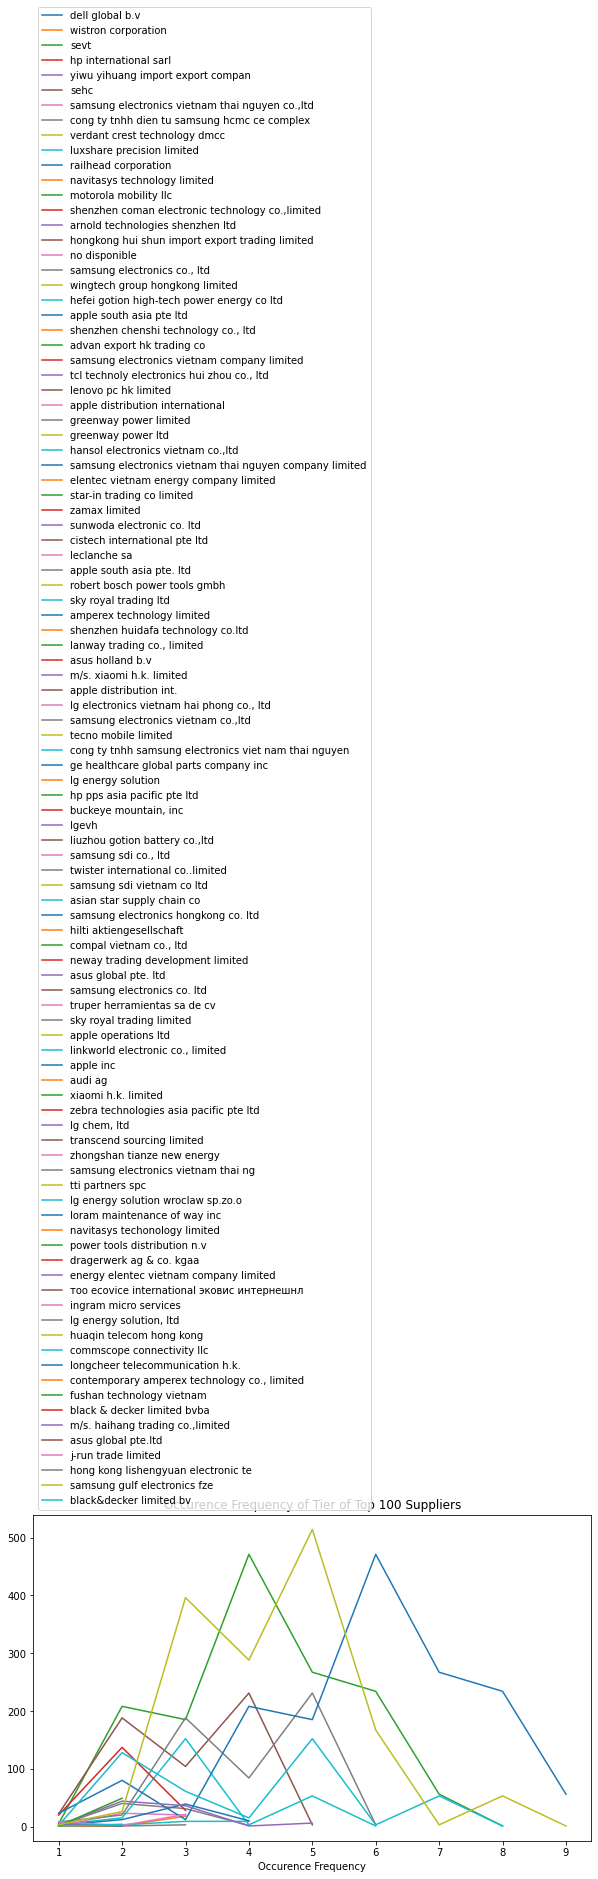

In [11]:
# Q1.2: Where's a supplier at in the supply chain? 
# A1.2: Plot for Top NUM_SUPPLIERS: x-axis is 'tier', y-axis is count of occurence
plt.figure(figsize=(10,6))
for bat in battery_suppliers[:NUM_SUPPLIERS]:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    tier_df = battery_subgraph[0].groupby(['tier'])['tier'].count()
    
    x = list(tier_df.index)
    y = list(tier_df.values)
    
    # check tier
    plt.plot(x, y, label = bat)

plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=1)
plt.xlabel("Tier")
plt.xlabel("Occurence Frequency")
plt.title("Occurence Frequency of Tier of Top " + str(NUM_SUPPLIERS) + " Suppliers")
plt.show()

## Q2: 'hs6' vs tier as tree depth mean across top suppliers. If BOM correct, we expect the empirical plot to be consistent

In [12]:
construct_battery_subgraph(['dell global b.v'], MAX_TIER)[0]['tier'].values[0] + 1

2

In [13]:
# Construct dicts to record hs_6 code and tier list
def construct_hs6_to_tier(battery_suppliers):
    hs6_dict = defaultdict(list) # set(hs_6(s)) -> tier mean, std, sum

    for bat in battery_suppliers:
        battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
        assert(battery_subgraph[1] < MAX_TIER)
        for _, row in battery_subgraph[0].iterrows():
            hs6_dict[row['hs6']].append(row['tier'])
    return hs6_dict

hs6_dict = construct_hs6_to_tier(battery_suppliers)

In [14]:
# Calculate tier info (mean, std, sum) per grouping, sum here means cnt of tx
# grouping is like BATTERY_PARTS_DICT: group_name -> list of hs6_code
def calculate_tier_info(hs6_dict, grouping=None):
    import statistics
    hs6_group_dict = defaultdict(list)
    if grouping == None:
        grouping = {hs6: [hs6] for hs6 in hs6_dict}

    for key in grouping:
        values = []
        for hs6 in grouping[key]:        
            values += hs6_dict[hs6]
        mean = statistics.mean(values) if len(values) > 0 else -1
        std = statistics.stdev(values) if len(values) > 1 else -1 # If stdev not applicable, use -1
        summ = len(values)
        hs6_group_dict[key] = [mean, std, summ]
    df = pd.DataFrame.from_dict(hs6_group_dict, orient='index', columns=['tier_mean','tier_std','tier_sum'])
    df = df.sort_values(['tier_mean'], ascending = False)
    return df

In [15]:
# Sanity check: info of BATTERY = 850760 row
# Sanity check: the ordering of index (hs6 code) should resemble BOM tree, not necessarily numerically equally-spaced

In [16]:
def plot_tier_info(df, category_label=False):
    # Add category label to hs code df index
    if category_label:
        category_index = []
        for hs6 in df.index:
            if hs6 in INV_BATTERY_PARTS_DICT:
                category_index.append(hs6 + ":" + INV_BATTERY_PARTS_DICT[hs6])
            else:
                category_index.append(hs6 + ":" + "Other")
        df["temp"] = category_index
        df = df.set_index("temp")
    
    
    # Plot of distribution of mean, sum, std
    plt.subplots(figsize=(15, 5))

    num_bins = round((max(df['tier_mean']) - min(df['tier_mean'])) * 4)

    plt.subplot(1, 3, 1)
    plt.hist(df['tier_mean'], bins=num_bins)
    plt.title('Distribution of tier mean')
    plt.xlabel('Tier Mean Value')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    plt.hist(df['tier_std'], bins=num_bins)
    plt.title('Distribution of tier stdev')
    plt.xlabel('Tier Stdev Value')
    plt.ylabel('Count')

    plt.subplot(1, 3, 3)
    plt.hist(df['tier_sum'], bins=num_bins)
    plt.title('Distribution of tier sum')
    plt.xlabel('Tier Sum Value')
    plt.ylabel('Count')

    # space between the plots
    plt.tight_layout()

    # show plot
    plt.show()
    
    # Per hs code: plot of mean, variance, overlapped with sum histogram
    x = np.array(df.index)
    y = np.array(df['tier_mean'].values)
    e = np.array(df['tier_std'].values)
    s = np.array(df['tier_sum'].values)

    SUM_SCALE = max(s) / 2

    plt.figure(figsize=(20, 10))
    plt.errorbar(x, y, e, linestyle='-', marker='*', ecolor='green')
    plt.bar(x, s / SUM_SCALE, alpha=0.5, label='sum') # Scaled to show trend (maximum is 2) not actual values
    plt.xticks(rotation = 90)
    plt.title("Per grouping, plot of mean with stdev error bar, overlapped with scaled sum historgram of tier values")
    plt.show()
    

,tier_mean,tier_std,tier_sum
850790,7.200000,1.483240,5
730711,7.200000,1.483240,5
722699,6.400000,1.646545,10
831190,5.750000,1.983629,24
760410,5.666667,1.714986,18
831110,5.588235,2.152290,17
740822,5.466667,1.407463,15
750522,5.200000,1.483240,5
730890,5.191489,1.895513,47
854290,5.187500,1.229673,32


/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


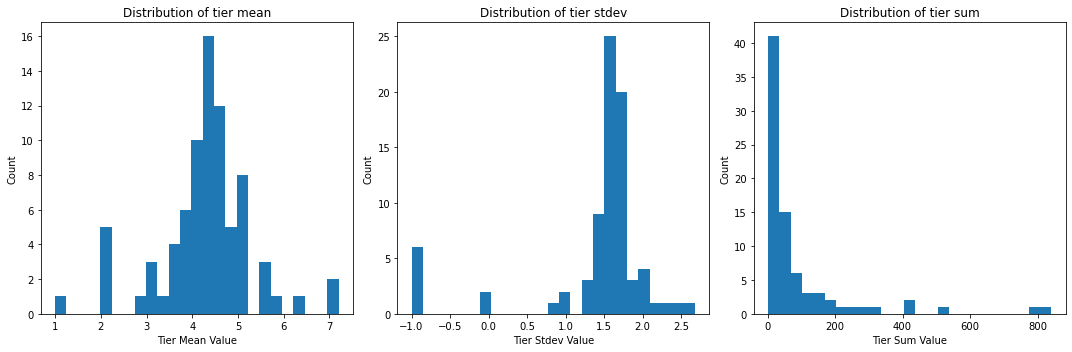

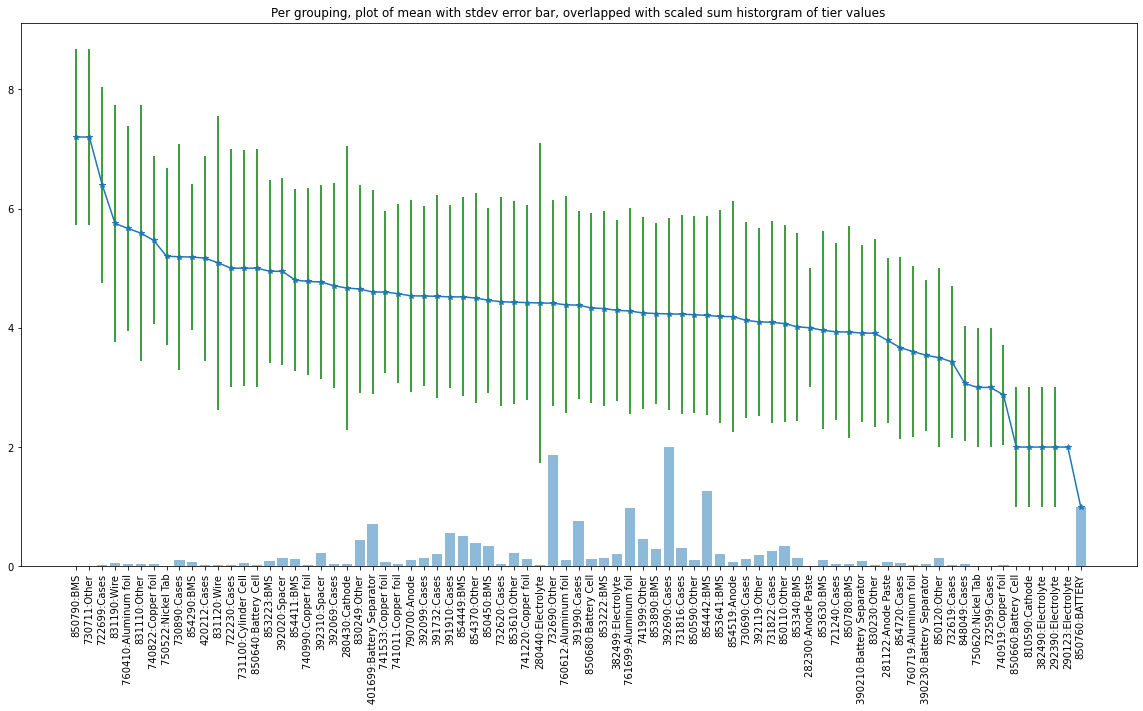

In [17]:
# Q2.1: Per hs_code, how does the graph look like?
df = calculate_tier_info(hs6_dict)
pd.set_option('display.max_rows', 100)
display(df)
pd.reset_option("all")

plot_tier_info(df, True)

,tier_mean,tier_std,tier_sum
Wire,5.542857,2.132974,35
Cylinder Cell,5.000000,1.977142,23
Spacer,4.834437,1.601793,151
Nickel Tab,4.833333,1.602082,6
Copper foil,4.531250,1.556988,128
Cathode,4.526316,2.389059,19
Battery Separator,4.492795,1.698973,347
Anode,4.383562,1.760919,73
Battery Cell,4.363636,1.648385,55
BMS,4.344040,1.651011,1401


/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


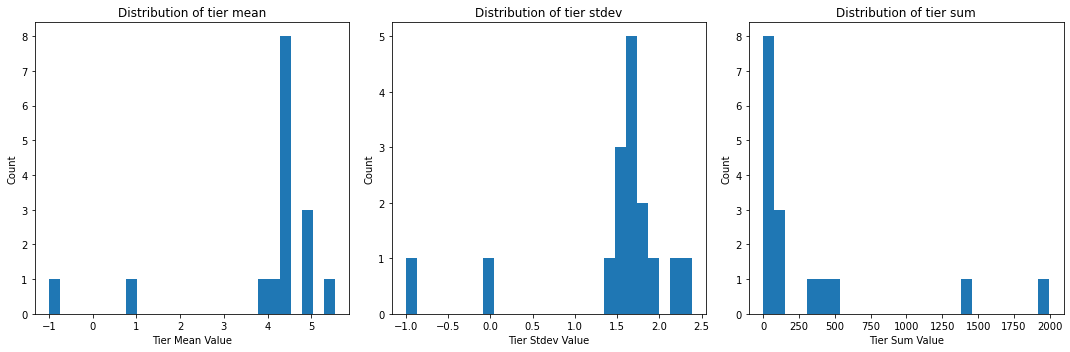

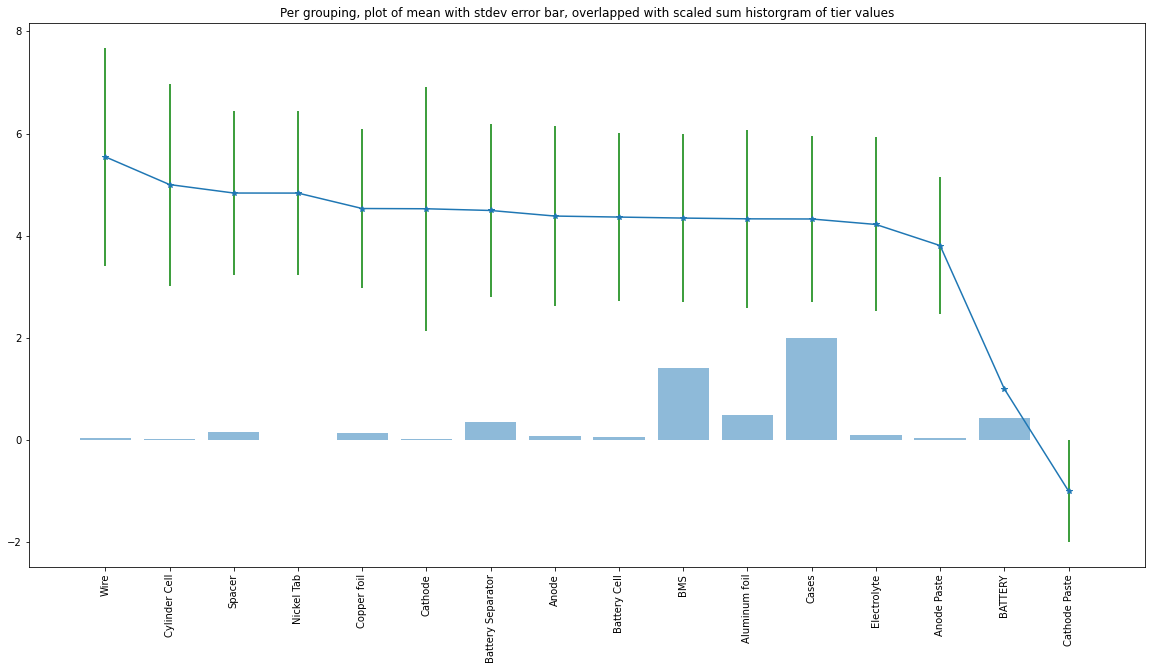

In [18]:
# Q2.2: Per bom grouping, how does the graph look like?
df = calculate_tier_info(hs6_dict, BATTERY_PARTS_DICT)
pd.set_option('display.max_rows', 100)
display(df)
pd.reset_option("all")

plot_tier_info(df)

In [19]:
# TODO: check for specific company

## Q3: Evaluate missingness
How many hs_codes we expect to see actually show up in the subgraph of the battery makers?

In [20]:
hs6_dict.keys()

dict_keys(['850760', '732690', '854370', '854449', '854442', '853610', '853890', '761699', '392690', '391990', '392119', '830249', '850120', '731822', '850110', '850780', '382499', '280430', '280440', '401699', '741999', '760612', '831190', '741220', '731816', '854519', '850680', '392310', '740919', '741533', '850450', '853340', '391910', '732620', '853630', '853641', '392099', '730690', '853222', '848049', '831110', '391732', '854411', '730890', '790700', '281122', '282300', '760410', '740990', '392020', '854290', '741011', '853223', '731100', '850590', '390210', '390230', '721240', '732619', '760719', '854720', '830230', '392069', '831120', '740822', '750522', '420212', '722230', '722699', '850640', '730711', '850790', '750620', '290123', '292390', '850660', '810590', '732599', '382490', '282110', '281700', '740811', '740921', '282200', '284210', '730120', '392051', '860900', '750610', '850730', '853321', '854190', '854239'])

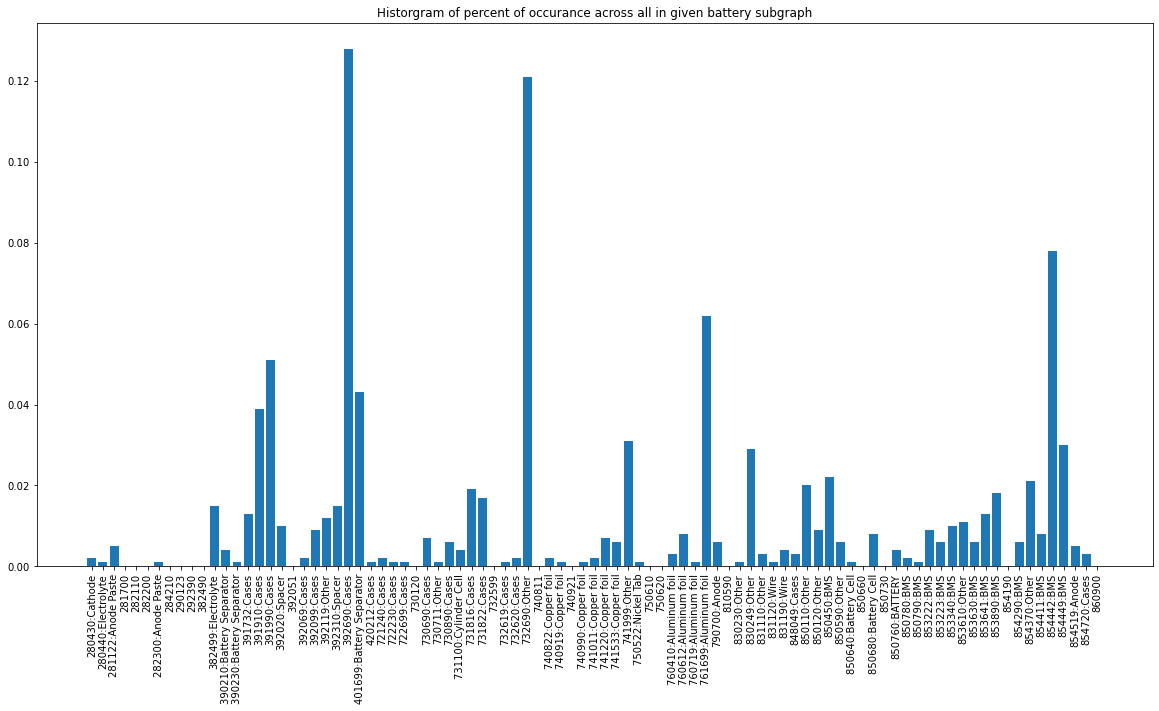

(                      count  percent
 temp                                
 392690:Cases            183    0.128
 732690:Other            173    0.121
 854442:BMS              111    0.078
 761699:Aluminum foil     89    0.062
 391990:Cases             73    0.051
 ...                     ...      ...
 850640:Battery Cell       1    0.001
 722230:Cases              1    0.001
 750522:Nickel Tab         1    0.001
 420212:Cases              1    0.001
 282300:Anode Paste        1    0.001
 
 [72 rows x 2 columns],
 {'281700',
  '282110',
  '282200',
  '284210',
  '290123',
  '292390',
  '382490',
  '392051',
  '730120',
  '732599',
  '740811',
  '740921',
  '750610',
  '750620',
  '810590',
  '850660',
  '850730',
  '854190',
  '860900'})

In [21]:
# Q3.1: given companies [list], construct subgraph and count distribution of hs_codes 
def evaluate_missingness(companies, plot=False, category_label=False):
    battery_subgraph = construct_battery_subgraph(companies, MAX_TIER)[0]
    dict_ = defaultdict(int)
    df = battery_subgraph.groupby(['hs6']).count() # col 'supplier_t' is a placeholder 
    df = df.rename(columns={"supplier_t": "count"})
    df['percent'] = round(df['count'] / df['count'].sum(), 3)
    df = df.sort_values(["count"], ascending = False)
        
    assert (set(df.index) - set(BATTERY_PARTS + [BATTERY])) == set()
    missing_parts = set(BATTERY_PARTS + [BATTERY]) - set(df.index)
    if plot:
        # Add category label to hs code df index
        if category_label:
            category_index = []
            for hs6 in df.index:
                if hs6 in INV_BATTERY_PARTS_DICT:
                    category_index.append(hs6 + ":" + INV_BATTERY_PARTS_DICT[hs6])
                else:
                    category_index.append(hs6 + ":" + "Other")
            df["temp"] = category_index
            df = df.set_index("temp")
        
        plt.figure(figsize=(20, 10))
        x = list(df.index) + list(missing_parts)
        y = list(df['percent'].values) + [0] * len(missing_parts)
        
        # Sort by hs code from small to large
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[0])
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Historgram of percent of occurance across all in given battery subgraph")
        plt.show()
    return df[["count", "percent"]], missing_parts

evaluate_missingness(battery_suppliers[2:3], True, True)

Parts in grouping holds 0.774 porportion of all hs6 codes.


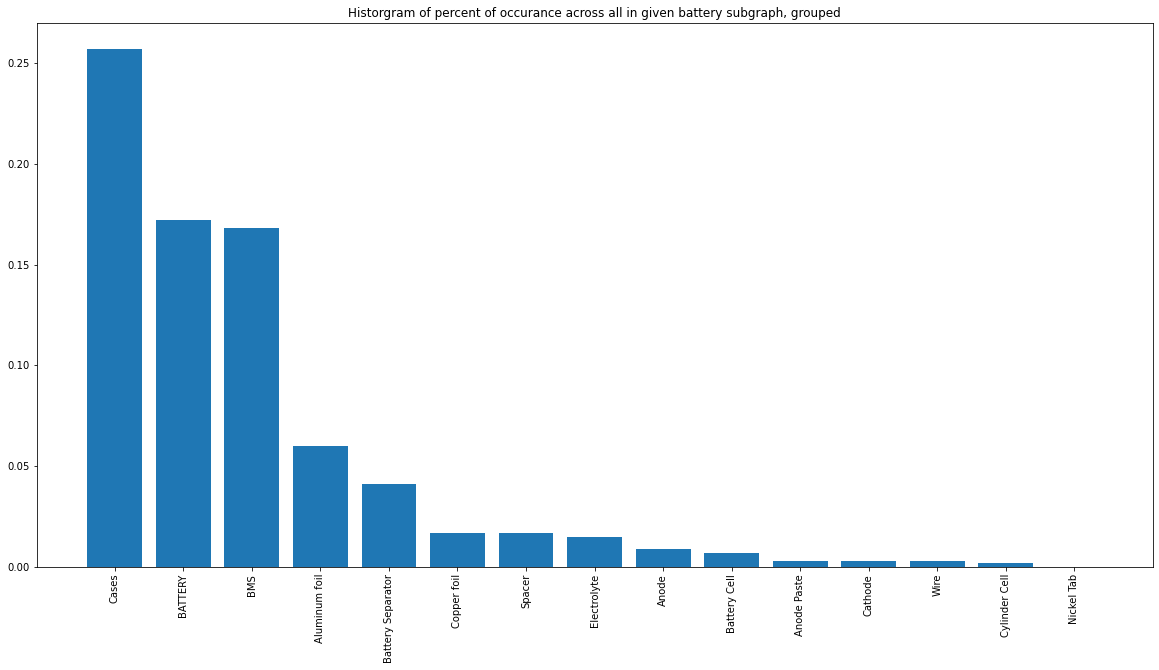

(                   count  percent
 hs6                              
 Aluminum foil        145    0.060
 Anode                 21    0.009
 Anode Paste            8    0.003
 BATTERY              420    0.172
 BMS                  412    0.168
 Battery Cell          17    0.007
 Battery Separator    100    0.041
 Cases                628    0.257
 Cathode                9    0.003
 Copper foil           40    0.017
 Cylinder Cell          6    0.002
 Electrolyte           39    0.015
 Nickel Tab             2    0.000
 Spacer                42    0.017
 Wire                   9    0.003,
 {'281700',
  '282110',
  '282200',
  '284210',
  '392051',
  '730120',
  '740811',
  '740921',
  '750610',
  '850730',
  '854190',
  '860900'})

In [22]:
# Q3.2: given companies [list], construct subgraph and count distribution by grouping of hs_codes
def evaluate_missingness_group(companies, grouping, plot=False):
    df, missing_parts = evaluate_missingness(companies)
    df = df.groupby(by=grouping, axis=0).sum()
    print("Parts in grouping holds", df['percent'].sum(), "porportion of all hs6 codes.")
    if plot:
        plt.figure(figsize=(20, 10))
        x = list(df.index)
        y = list(df['percent'].values)
        
        # Sort by value from large to small
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Historgram of percent of occurance across all in given battery subgraph, grouped")
        plt.show()
    return df[["count", "percent"]], missing_parts

evaluate_missingness_group(battery_suppliers[0:NUM_SUPPLIERS], INV_BATTERY_PARTS_DICT, True)

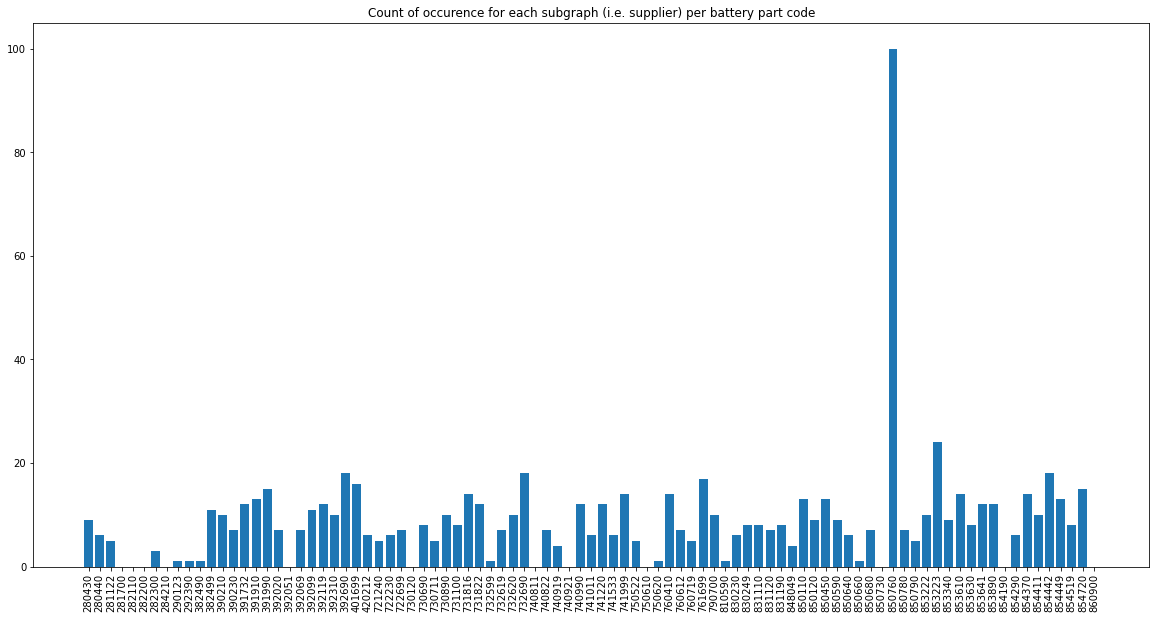

,cnt
281700,0
282200,0
392020,7
392051,0
392119,12
...,...
392690,18
730890,10
731100,8
853641,12


In [23]:
# Q3.3: count of subgraphs that has each battery part code?
def supplier_cnt_per_battery_part(suppliers, plot=False):
    cnt_dict = dict.fromkeys(BATTERY_PARTS + [BATTERY], 0)
    for supplier in suppliers:
        subgraph_df = construct_battery_subgraph([supplier], MAX_TIER)[0]
        subgraph_hs6_set = set(subgraph_df['hs6'])
        for hs6 in BATTERY_PARTS + [BATTERY]:
            cnt_dict[hs6] += (hs6 in subgraph_hs6_set)
            
    cnt_df = pd.DataFrame.from_dict(cnt_dict, orient='index', columns=["cnt"])
    
    if plot:
        plt.figure(figsize=(20, 10))
        x = list(cnt_dict.keys())
        y = list(cnt_dict.values())
        
        # Sort by hs code from small to large
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[0])
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Count of occurence for each subgraph (i.e. supplier) per battery part code")
        plt.show()

    return cnt_df
supplier_cnt_per_battery_part(battery_suppliers[0:NUM_SUPPLIERS], True) 

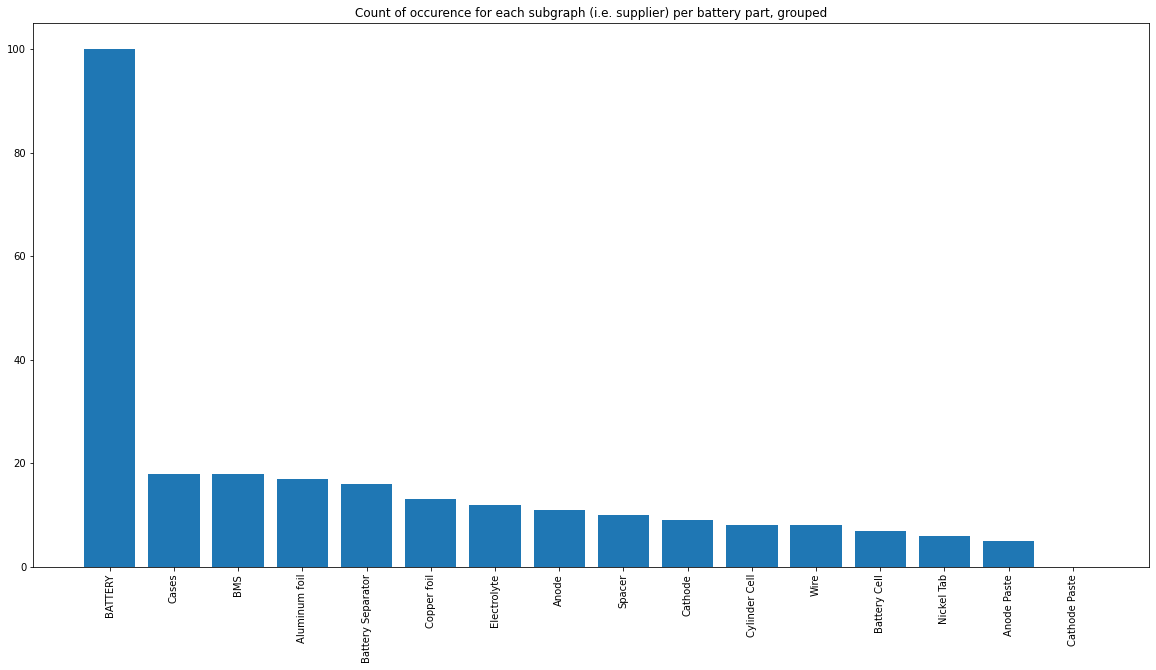

,cnt
Aluminum foil,17
Anode Paste,5
Copper foil,13
Cathode,9
Cathode Paste,0
Electrolyte,12
Battery Separator,16
Anode,11
Cylinder Cell,8
Spacer,10


In [24]:
# Q3.4: count of subgraphs that has each battery part?
def supplier_cnt_per_battery_part_group(suppliers, grouping, plot=False):
    cnt_dict = dict.fromkeys(BATTERY_PARTS_DICT.keys(), 0)
    for supplier in suppliers:
        subgraph_df = construct_battery_subgraph([supplier], MAX_TIER)[0]
        subgraph_hs6_set = set(subgraph_df['hs6'])
        for key in cnt_dict.keys():
            target_hs6_set = set(grouping[key])
            cnt_dict[key] += (len(target_hs6_set.intersection(subgraph_hs6_set)) != 0)
            
    cnt_df = pd.DataFrame.from_dict(cnt_dict, orient='index', columns=["cnt"])
    
    if plot:
        plt.figure(figsize=(20, 10))
        x = list(cnt_dict.keys())
        y = list(cnt_dict.values())
        
        # Sort by value from large to small
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Count of occurence for each subgraph (i.e. supplier) per battery part, grouped")
        plt.show()

    return cnt_df

supplier_cnt_per_battery_part_group(battery_suppliers[0:NUM_SUPPLIERS], BATTERY_PARTS_DICT, True) 

# Q4: Flow of the network

In [25]:
# Q4.1: evaluate PMI of product_sold and product_bought for each pair in BOM?
def compute_pmis(all_companies, max_degree=1):
    """
    Computes pointwise mutual information (PMI) for each pair of (product_sold, product_bought).
    """
    bom_df = index[index['hs6'].isin(BATTERY_PARTS + [BATTERY])].copy()
    bom_df = bom_df[(bom_df['supplier_t'].isin(all_companies)) | (bom_df['buyer_t'].isin(all_companies))]
    
    # get pairs of supplier, product
    supplier_pairs = bom_df.groupby(['supplier_t', 'hs6']).size().reset_index().rename(columns={'supplier_t': 'company', 'hs6': 'product_sold'})
    
    # get pairs of buyer, product
    buyer_pairs = bom_df.groupby(['buyer_t', 'hs6']).size().reset_index().rename(columns={'buyer_t': 'company', 'hs6': 'product_bought'})
        
    # get triplets of company, product sold, product bought
    triplets = pd.merge(supplier_pairs[['company', 'product_sold']], buyer_pairs[['company', 'product_bought']], how='inner', 
                        left_on='company', right_on='company')
    test_company = triplets.iloc[0].company
    num_products_sold = len(supplier_pairs[supplier_pairs.company == test_company])
    num_products_bought = len(buyer_pairs[buyer_pairs.company == test_company])
    assert (num_products_sold * num_products_bought) == len(triplets[triplets.company == test_company])
    
    # compute p(sell product A and buy product B)
    product_pairs = triplets.groupby(['product_sold', 'product_bought']).size().rename('num_product_pair').reset_index()
    product_pairs['p_product_pair'] = product_pairs.num_product_pair / len(all_companies)
        
    # compute p(sell product) and p(buy product)
    num_suppliers_and_buyers = bom_df.groupby('hs6')[['supplier_t', 'buyer_t']].nunique()
    prob_supply_and_buy = (num_suppliers_and_buyers / len(all_companies)).rename(columns={'supplier_t': 'p_product_sold', 'buyer_t': 'p_product_bought'})
    product_pairs = pd.merge(product_pairs, prob_supply_and_buy.p_product_sold, how='left', left_on='product_sold', right_index=True)
    product_pairs = pd.merge(product_pairs, prob_supply_and_buy.p_product_bought, how='left', left_on='product_bought', right_index=True)
    product_pairs['p_multiplied'] = product_pairs['p_product_sold'] * product_pairs['p_product_bought']
    product_pairs['pmi'] = np.log(product_pairs['p_product_pair'] / product_pairs['p_multiplied'])
    for k in range(2, max_degree+1):
        # pmi^k is known to alleviate issues with low frequency
        product_pairs[f'pmi^{k}'] = np.log((product_pairs['p_product_pair']**k) / product_pairs['p_multiplied'])
    return product_pairs

# Generate PMIS table
all_companies = set(index.buyer_t.unique()).union(index.supplier_t.unique()) # NOT USED

pmis = compute_pmis(battery_suppliers, max_degree=3)
print("PMIS table below")
display(pmis.head(), round(4))

# Investigate product sold, product bought pairs
PRODUCT_SOLD_BOUGHT = {
    'BATTERY': ['Battery Cell', 'Spacer', 'BMS', 'Wire', 'Cases', 'Nickel Tab'],
    'Battery Cell': ['Cathode', 'Electrolyte', 'Battery Separator', 'Anode', 'Cylinder Cell'],
    'Cathode': ['Cathode Paste', 'Aluminum foil'],
    'Anode': ['Anode Paste', 'Copper foil']
}
for ps_label in PRODUCT_SOLD_BOUGHT:
    ps = BATTERY_PARTS_DICT[ps_label]
    for pb_label in PRODUCT_SOLD_BOUGHT[ps_label]:
        pb = BATTERY_PARTS_DICT[pb_label]
        print("Product Sold:", ps_label, "and Product Bought:", pb_label)
        display(pmis[(pmis.product_sold.isin(ps)) & (pmis.product_bought.isin(pb))])

PMIS table below


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
0,280430,391990,1,0.01,0.03,0.87,0.0261,-0.959350,-5.564520,-10.169691
1,280430,392690,1,0.01,0.03,1.66,0.0498,-1.605430,-6.210600,-10.815770
2,280430,401699,1,0.01,0.03,0.72,0.0216,-0.770108,-5.375278,-9.980449
3,280430,731816,1,0.01,0.03,0.64,0.0192,-0.652325,-5.257495,-9.862666
4,280430,731822,1,0.01,0.03,0.55,0.0165,-0.500775,-5.105945,-9.711116


4

Product Sold: BATTERY and Product Bought: Battery Cell


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1974,850760,850640,1,0.01,1.33,0.02,0.0266,-0.978326,-5.583496,-10.188666
1975,850760,850660,1,0.01,1.33,0.01,0.0133,-0.285179,-4.890349,-9.495519
1976,850760,850680,5,0.05,1.33,0.09,0.1197,-0.872966,-3.868698,-6.864430


Product Sold: BATTERY and Product Bought: Spacer


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1932,850760,392020,2,0.02,1.33,0.11,0.1463,-1.989927,-5.901950,-9.813973
1936,850760,392310,6,0.06,1.33,0.22,0.2926,-1.584462,-4.397873,-7.211283


Product Sold: BATTERY and Product Bought: BMS


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1972,850760,850450,11,0.11,1.33,0.41,0.5453,-1.600856,-3.808131,-6.015406
1978,850760,850780,4,0.04,1.33,0.13,0.1729,-1.463834,-4.682710,-7.901586
1979,850760,853222,9,0.09,1.33,0.21,0.2793,-1.132477,-3.540422,-5.948368
1980,850760,853223,4,0.04,1.33,0.10,0.1330,-1.201470,-4.420345,-7.639221
1981,850760,853340,7,0.07,1.33,0.39,0.5187,-2.002830,-4.662090,-7.321351
1983,850760,853630,6,0.06,1.33,0.14,0.1862,-1.132477,-3.945888,-6.759298
1984,850760,853641,8,0.08,1.33,0.24,0.3192,-1.383791,-3.909520,-6.435249
1985,850760,853890,11,0.11,1.33,0.54,0.7182,-1.876268,-4.083543,-6.290818
1986,850760,854290,1,0.01,1.33,0.03,0.0399,-1.383791,-5.988961,-10.594132
1988,850760,854411,4,0.04,1.33,0.06,0.0798,-0.690644,-3.909520,-7.128396


Product Sold: BATTERY and Product Bought: Wire


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1967,850760,831120,2,0.02,1.33,0.04,0.0532,-0.978326,-4.890349,-8.802372
1968,850760,831190,2,0.02,1.33,0.08,0.1064,-1.671473,-5.583496,-9.495519


Product Sold: BATTERY and Product Bought: Cases


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1929,850760,391732,7,0.07,1.33,0.22,0.2926,-1.430311,-4.089571,-6.748831
1930,850760,391910,12,0.12,1.33,0.41,0.5453,-1.513844,-3.634108,-5.754371
1931,850760,391990,18,0.18,1.33,0.87,1.1571,-1.860715,-3.575514,-5.290312
1933,850760,392069,1,0.01,1.33,0.04,0.0532,-1.671473,-6.276643,-10.881814
1934,850760,392099,7,0.07,1.33,0.19,0.2527,-1.283708,-3.942968,-6.602228
1937,850760,392690,18,0.18,1.33,1.66,2.2078,-2.506795,-4.221593,-5.936392
1939,850760,721240,1,0.01,1.33,0.02,0.0266,-0.978326,-5.583496,-10.188666
1940,850760,722230,1,0.01,1.33,0.02,0.0266,-0.978326,-5.583496,-10.188666
1941,850760,730690,6,0.06,1.33,0.13,0.1729,-1.058369,-3.871780,-6.685190
1942,850760,730890,5,0.05,1.33,0.08,0.1064,-0.755183,-3.750915,-6.746647


Product Sold: BATTERY and Product Bought: Nickel Tab


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1956,850760,750522,1,0.01,1.33,0.01,0.0133,-0.285179,-4.890349,-9.495519
1957,850760,750620,1,0.01,1.33,0.01,0.0133,-0.285179,-4.890349,-9.495519


Product Sold: Battery Cell and Product Bought: Cathode


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3


Product Sold: Battery Cell and Product Bought: Electrolyte


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1867,850680,382499,1,0.01,0.07,0.28,0.0196,-0.672944,-5.278115,-9.883285


Product Sold: Battery Cell and Product Bought: Battery Separator


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1868,850680,390210,2,0.02,0.07,0.06,0.0042,1.560648,-2.351375,-6.263398
1869,850680,390230,1,0.01,0.07,0.02,0.0014,1.966113,-2.639057,-7.244228
1879,850680,401699,3,0.03,0.07,0.72,0.0504,-0.518794,-4.025352,-7.531910


Product Sold: Battery Cell and Product Bought: Anode


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1893,850680,790700,1,0.01,0.07,0.20,0.0140,-0.336472,-4.941642,-9.546813
1913,850680,854519,1,0.01,0.07,0.06,0.0042,0.867501,-3.737670,-8.342840


Product Sold: Battery Cell and Product Bought: Cylinder Cell


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1883,850680,731100,1,0.01,0.07,0.03,0.0021,1.560648,-3.044522,-7.649693


Product Sold: Cathode and Product Bought: Cathode Paste


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3


Product Sold: Cathode and Product Bought: Aluminum foil


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
9,280430,761699,1,0.01,0.03,0.55,0.0165,-0.500775,-5.105945,-9.711116


Product Sold: Anode and Product Bought: Anode Paste


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1439,790700,281122,1,0.01,0.13,0.06,0.0078,0.248461,-4.356709,-8.961879


Product Sold: Anode and Product Bought: Copper foil


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1463,790700,740822,1,0.01,0.13,0.01,0.0013,2.040221,-2.564949,-7.170120
1464,790700,740990,1,0.01,0.13,0.02,0.0026,1.347074,-3.258097,-7.863267
1465,790700,741011,2,0.02,0.13,0.05,0.0065,1.123930,-2.788093,-6.700116
1466,790700,741220,2,0.02,0.13,0.22,0.0286,-0.357674,-4.269697,-8.181720
1467,790700,741533,1,0.01,0.13,0.11,0.0143,-0.357674,-4.962845,-9.568015
2578,854519,741220,1,0.01,0.09,0.22,0.0198,-0.683097,-5.288267,-9.893437


# Battery & BMS: 
'''
1. Companies that purchases BMS and sells battery
2. Signs of propagation? What time scale? Go into their transactions, plot out quarter by quarter, aggregated BMS, battery.
3. Correlation (Pearson)
    a. BMS, Battery time series
    b. Global parameter needed? across companies
4. Poisson? 
'''